In [1]:
import pandas as pd
import numpy as np

In [20]:
data = pd.read_csv('store_unified_summary.csv', encoding='utf-8-sig')

In [22]:
# 1. 제외할 컬럼 정의
exclude_cols = [
    "store_id", "owner_id",
    "open_date", "summary_year_month", "created_dttm", "updated_dttm", "last_updated_dttm"
]

# 2. 연속형 숫자형 컬럼만 선택 (INT, FLOAT/DECIMAL)
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()

# 3. 제외 컬럼 제거 후 잡음 대상 컬럼만 추출
target_cols = [col for col in numeric_cols if col not in exclude_cols]

# 4. 잡음 추가 함수 정의
def add_noise(series, noise_level=0.01):
    """series 값에 표준편차 기반 랜덤 잡음 추가"""
    std = series.std()
    noise = np.random.normal(0, noise_level * std, size=series.shape)
    return series + noise

# 5. 잡음 추가 적용
data_noisy = data.copy()
data_noisy[target_cols] = data_noisy[target_cols].apply(lambda col: add_noise(col, noise_level=0.01))

In [23]:
pd.set_option('display.max_columns', None)
data_noisy.head()

,store_id,owner_id,business_registration_no,industry_code,open_date,summary_year_month,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,weekday_avg_transaction_value,weekend_avg_transaction_value,cash_payment_ratio,card_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,created_dttm,updated_dttm,last_updated_dttm,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,operating_expenses,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,operating_expense_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,101,1101,101-74-60399,56112.492220,2024-11-04,2024-11,2.914500e+06,1.487105e+06,1.157659e+06,31.880613,26.722939,162.201206,93.943729,87.998900,1.166290,NaN,0.142595,16130.601646,15263.230415,18230.627684,15.645055,84.470299,40.332698,53.702950,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,866.196843,111754.542561,502.144473,9.262955,35.600224,0.005032,-0.001053,6.506292,5.176904,0.003135,-0.932578,2558.613470,0.017741,3.898685,50.626653,-0.000310,0.001536,365149.903982,1.377106e+06,422629.210118,2.664845e+06,320309.638703,291498.234772,14.353208,48.442449,15.507879,11.262586,85.694444,53.240474,44.509385,2.181089,1.219831,0.390694,1.820795e+06,60.057542,2.792279,62.040688,72.664463,59.874776,68.653260
1,101,1101,101-80-14374,56111.760740,2024-11-04,2024-12,3.021302e+06,1.916500e+06,1.394906e+06,24.712312,26.410375,155.790556,111.004736,92.976523,13.782679,NaN,0.164949,16890.162266,15865.461510,18830.712295,19.269992,80.628609,50.623325,69.517155,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,1138.830360,128612.810147,693.348421,8.562840,39.565501,-0.001550,-0.001151,8.216848,9.949611,-0.008833,0.163779,1194.979002,-0.001631,3.793039,59.492638,0.002667,-0.004417,463803.187138,1.770143e+06,618838.109097,2.263632e+06,341965.235226,246585.154501,12.707734,51.676127,17.221821,10.306391,87.299088,64.371764,33.161882,2.506518,0.962100,0.506968,2.034436e+06,42.354350,2.013844,77.889890,46.003412,54.946550,72.752379
2,101,1101,101-90-34754,56112.550936,2024-11-04,2025-01,3.604233e+06,2.158519e+06,1.447443e+06,20.221484,26.362401,153.807957,104.882454,77.668921,12.158115,NaN,0.147917,18603.385884,17589.380244,20928.035457,15.956582,84.319855,50.871412,63.596665,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,1084.786827,129570.563029,747.981998,8.095984,60.766251,0.000723,-0.000473,6.919772,6.001423,-0.004699,-0.076092,2762.451952,-0.002629,3.859087,57.408528,0.001984,-0.005807,472407.540521,1.637662e+06,541805.109465,3.022364e+06,369731.047293,348300.018130,15.464404,48.170919,15.274333,10.995950,84.499229,63.220463,32.574145,4.002630,1.021350,0.576891,1.936806e+06,38.511343,0.973831,68.305483,61.932595,75.141805,88.980093
3,101,1101,101-04-50959,56111.334664,2024-11-04,2025-02,4.068355e+06,2.121266e+06,1.786815e+06,26.368072,33.699834,216.607746,103.294141,100.153360,13.322389,NaN,0.171970,20500.046770,19437.623797,23144.141852,18.399419,81.669713,49.814455,60.088186,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,908.044529,105337.880119,623.679050,8.080276,37.806641,-0.005949,0.002543,5.473653,6.324946

In [24]:
# ==============================
# 패키지 불러오기
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from factor_analyzer import FactorAnalyzer, calculate_bartlett_sphericity, calculate_kmo
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# ==============================
# 1. 스케일링
# ==============================
# R: X_df <- df[, 11:18]; X_df <- X_df[, -1]
data_noisy2 = data_noisy.drop(data_noisy.columns[[0, 1]], axis=1)

# 1. 숫자형 컬럼만 선택
numeric_cols = data_noisy2.select_dtypes(include=["int64", "float64"]).columns

# exclude_cols 제거
target_cols = [col for col in numeric_cols if col not in exclude_cols]

# 표준화 수행
scaler = StandardScaler()
standardized_X = pd.DataFrame(
    scaler.fit_transform(data_noisy[target_cols]),
    columns=target_cols
)

# 원본 데이터에 반영하고 싶으면
data_standardized = data_noisy.copy()
data_standardized[target_cols] = standardized_X

In [25]:
data_standardized

,store_id,owner_id,business_registration_no,industry_code,open_date,summary_year_month,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,weekday_avg_transaction_value,weekend_avg_transaction_value,cash_payment_ratio,card_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,created_dttm,updated_dttm,last_updated_dttm,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,operating_expenses,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,operating_expense_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,101,1101,101-74-60399,-0.497384,2024-11-04,2024-11,-0.582278,-0.602565,-0.561329,0.408418,-0.186683,-0.631533,-0.666324,-0.545066,0.214559,NaN,0.193143,-0.033438,-0.018647,-0.013127,-0.762123,0.772636,-1.369136,0.325863,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-1.207612,-1.114695,-0.402971,-1.445231,-1.462264,-0.562076,-0.466783,-0.812221,-0.956986,-0.772815,-0.504387,-0.637893,-0.438831,-0.087841,-0.697469,-0.247835,-0.275700,-0.580570,-0.581001,-0.598440,-0.574544,-0.580974,-0.577961,-0.702494,0.373347,-0.707407,0.977328,0.712496,-0.353738,0.448836,-1.350928,0.223555,-0.800322,-0.550748,-0.148545,0.212214,-0.936175,0.082466,-0.614208,-0.899929
1,101,1101,101-80-14374,-0.514471,2024-11-04,2024-12,-0.578536,-0.578531,-0.539606,-0.515822,-0.217535,-0.634794,-0.651453,-0.539130,3.438549,NaN,0.543221,0.075462,0.073233,0.063684,-0.403244,0.392464,-0.602472,1.476952,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-0.864243,-0.940004,0.103568,-1.524848,-1.196342,-0.577335,-0.467042,-0.521550,-0.130901,-0.797502,-0.473130,-0.645544,-0.461731,-0.305414,0.090919,-0.235044,-0.285679,-0.563432,-0.551763,-0.555539,-0.592052,-0.573139,-0.598575,-1.065048,1.626941,0.452592,0.135538,1.066114,1.196561,-1.117143,-0.789159,-1.216539,-0.361172,-0.542880,-1.061771,-0.147521,0.120745,-1.635676,-0.919427,-0.542667
2,101,1101,101-90-34754,-0.496013,2024-11-04,2025-01,-0.558111,-0.564984,-0.534796,-1.094845,-0.222271,-0.635802,-0.656789,-0.557383,3.023408,NaN,0.276489,0.321090,0.336243,0.332144,-0.731281,0.757748,-0.583989,1.046010,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-0.932309,-0.930079,0.248304,-1.577938,0.225437,-0.572066,-0.465266,-0.741960,-0.814274,-0.788975,-0.479968,-0.636750,-0.462910,-0.169392,-0.094406,-0.237979,-0.288009,-0.561938,-0.561618,-0.572382,-0.558942,-0.563095,-0.551890,-0.457659,0.268084,-0.865471,0.742594,0.449105,1.036214,-1.198252,1.793489,-0.885476,-0.097084,-0.546475,-1.260013,-0.628139,-0.518400,-0.609137,0.331324,0.871674
3,101,1101,101-04-50959,-0.524423,2024-11-04,2025-02,-0.541849,-0.567069,-0.503723,-0.302338,0.501978,-0.603855,-0.658174,-0.530573,3.320926,NaN,0.653178,0.593019,0.618221,0.615809,-0.489433,0.495491,-0.662734,0.790634,2025-09-08 00:21:10,2025-09-08 00:21:18,2025-09-08 00:21:10,-1.154907,-1.181186,-0.081000,-1.579725,-1.314296,-0.587536,-0.457372,-0.987696,-0.758277,-0.791330,-0.488789,-0.641844,-0.467745,-1.408282,-0.625854,-0.245713,-0.274633,-0.530815,-0.535066,-0.537928,-0.528704,-0.553414,-0.524686,-0.601541,0.514346,0.706933,-0.942038,0.607976,0.065093,-0.089817,0.

In [27]:
from sklearn.feature_selection import VarianceThreshold
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# ===============================
# 1) 제외할 컬럼 정의 (id, 날짜, boolean)
# ===============================
exclude_cols = [
    "store_id", "owner_id",
    "open_date", "summary_year_month", "created_dttm", "updated_dttm", "last_updated_dttm"
]

# ===============================
# 2) 숫자형 컬럼만 선택 후 exclude_cols 제거
# ===============================
numeric_cols = data_standardized.select_dtypes(include=["int64", "float64"]).columns
validation_cols = [col for col in numeric_cols if col not in exclude_cols]
X_validation = data_standardized[validation_cols]

# ===============================
# 3) NaN / Inf 제거
# ===============================
X_validation = X_validation.replace([np.inf, -np.inf], np.nan).dropna()

# ===============================
# 4) 분산 거의 0 컬럼 제거
# ===============================
selector = VarianceThreshold(threshold=1e-5)
X_validation_filtered = pd.DataFrame(
    selector.fit_transform(X_validation),
    columns=X_validation.columns[selector.get_support()]
)

# ===============================
# 5) 상관 높은 컬럼 제거 (선택적으로)
# ===============================
corr_matrix = X_validation_filtered.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.999)]
X_validation_filtered = X_validation_filtered.drop(columns=to_drop)

# ===============================
# 6) Bartlett's Test
# ===============================

print("Data shape after preprocessing:", X_validation_filtered.shape)
chi_square_value, p_value = calculate_bartlett_sphericity(X_validation_filtered)
print("Bartlett’s test: Chi-square =", chi_square_value, " p-value =", p_value)

# ===============================
# 7) KMO Test
# ===============================
kmo_all, kmo_model = calculate_kmo(X_validation_filtered)
print("KMO Model:", kmo_model)

Data shape after preprocessing: (392, 54)
Bartlett’s test: Chi-square = 43922.83156481499  p-value = 0.0
KMO Model: 0.8560170193387104


/Users/ahnsaeyeon/guide-on/ai/guide-on-ai/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [28]:
X_validation_filtered.head()

,industry_code,total_sales_amount,weekday_sales_amount,weekend_sales_amount,lunch_sales_ratio,dinner_sales_ratio,transaction_count,weekday_transaction_count,weekend_transaction_count,mom_growth_rate,yoy_growth_rate,sales_cv,avg_transaction_value,cash_payment_ratio,revisit_customer_sales_ratio,new_customer_ratio,electricity_usage_kwh,electricity_bill_amount,gas_usage_m3,water_usage_ton,energy_eff_appliance_ratio,participate_energy_eff_support,participate_high_eff_equip_support,food_waste_kg_per_day,recycle_waste_kg_per_day,yellow_umbrella_member,yellow_umbrella_months,yellow_umbrella_amount,employment_insurance_employees,customer_review_avg_rating,customer_review_positive_ratio,hygiene_certified,origin_price_violation_count,operating_profit,cost_of_goods_sold,total_salary,rent_expense,other_expenses,operating_profit_ratio,cogs_ratio,salary_ratio,rent_ratio,cash_payment_ratio_detail,card_payment_ratio_detail,other_payment_ratio,weighted_avg_cash_period,cashflow_cv,avg_account_balance,min_balance_maintenance_ratio,excessive_withdrawal_frequency,rent_payment_compliance_rate,utility_payment_compliance_rate,salary_payment_regularity,tax_payment_integrity
0,-0.503279,-0.359979,-0.393256,-0.311200,0.543575,0.691526,-0.526584,-0.578219,-0.450074,1.115323,1.215128,-0.138568,1.219859,0.288827,-0.052369,0.774314,0.314589,0.471479,1.308778,0.104881,-0.548005,-0.585324,2.151533,0.137193,-0.012461,-0.778883,-0.461103,-0.654172,-0.440728,-0.669718,0.254194,-0.243166,1.395092,-0.412985,-0.345265,-0.324449,-0.400464,-0.301905,-0.436310,0.127291,1.118615,-0.824223,0.294878,-0.325667,0.001099,-0.316938,0.654227,-0.401746,-1.259763,2.562216,-0.036091,-0.428906,-0.427476,-1.118664
1,-0.495506,-0.344509,-0.405067,-0.274837,-0.515605,0.814296,-0.498380,-0.566462,-0.443798,0.987715,1.208846,-0.134603,1.119358,0.594217,-0.296617,0.902854,0.150771,0.078440,1.418700,-0.707033,0.600969,-0.585071,-0.470745,-0.012234,0.095644,-0.768589,-0.484518,-0.648693,-0.462912,0.220803,0.389703,-0.243030,-0.253019,-0.406544,-0.343106,-0.369143,-0.302190,-0.266974,-0.603175,0.737803,-1.237408,0.571932,-0.482216,0.642595,-1.625069,0.373470,2.715214,-0.396675,-0.911220,-1.064669,0.684578,-0.840830,-1.660638,-1.268403
2,-0.487376,-0.311250,-0.385408,-0.255638,-0.733074,0.217288,-0.478613,-0.526554,-0.420775,1.158660,1.203420,0.233849,0.888941,-0.114385,-0.838728,1.377237,-0.720987,-0.713265,0.198130,-0.132248,-0.962591,-0.570182,2.161325,-0.314862,0.061913,-0.775524,-0.478023,-0.645866,-0.463294,0.177444,-0.145462,-0.253550,-0.282964,-0.333805,-0.327567,-0.390674,-0.309379,-0.271980,-0.051795,0.642581,-2.145013,0.590016,0.934120,-0.979570,0.080351,-0.949407,1.590486,-0.427401,-1.132905,-0.888891,-0.736209,-1.353409,0.112150,-1.113803
3,-0.480579,-0.304397,-0.373372,-0.231338,-0.514958,-0.015803,-0.518179,-0.533241,-0.425456,0.993623,1.193983,0.161686,1.129623,0.482308,-0.534946,0.265988,-0.686011,-0.736414,-0.651961,0.068086,-1.816059,-0.578033,-0.466984,-0.058746,0.053841,-0.776256,-0.495462,-0.651749,-0.448822,0.425585,0.251249,-0.232615,-0.269771,-0.315931,-0.308367,-0.303590,-0.315106,-0.294235,-0.067034,0.116348,0.321849,-0.679955,-0.207673,0.290885,-1.036459,0.105448,0.364048,-0.368468,-1.483826,-0.658492,-1.462553,0.004352,0.493307,-0.067389
4,-0.487351,-0.296467,-0.344429,-0.224993,-0.818099,-0.325522,-0.502541,-0.558971,-0.430557,1.363885,1.193850,0.611220,1.632381,-0.472299,-1.250480,0.885784,-0.949227,-0.851089,-0.673283,-0.279408,-0.866095,1.748241,-0.450035,0.140457,-0.156885,1.295482,-0.236618,1.033945,-0.454277,0.423120,0.833915,-0.231866,1.393071,-0.236800,-0.263452,-0.317368,-0.407983,-0.292914,0.832514,0.480714,-1.290015,-2.733006,-1.220613,1.098923,1.234178,1.283318,1.075518,-0.383462,-1.541321,0.825016,0.671455,-1.454440,0.700964,-0.263502


/Users/ahnsaeyeon/guide-on/ai/guide-on-ai/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Eigenvalues: [1.85570204e+01 8.63435966e+00 5.71156473e+00 2.74765249e+00
 2.40729158e+00 1.60813255e+00 1.30534027e+00 1.23641762e+00
 1.05853104e+00 1.03992518e+00 1.00385272e+00 9.50438767e-01
 9.34495442e-01 8.37767974e-01 8.04071418e-01 7.86579444e-01
 7.77342898e-01 7.24974402e-01 6.95676441e-01 6.82829293e-01
 6.65392663e-01 6.47866034e-01 5.99527537e-01 5.55262719e-01
 5.26088447e-01 5.04249658e-01 4.40450344e-01 3.74759025e-01
 3.38792766e-01 3.01033593e-01 2.47470421e-01 2.01782046e-01
 1.77522993e-01 1.64635781e-01 1.56100971e-01 1.55305021e-01
 1.17246125e-01 1.06676489e-01 5.54381900e-02 3.93459390e-02
 3.51530198e-02 2.66580280e-02 1.99236146e-02 1.31528309e-02
 7.30050170e-03 7.03472908e-03 6.28600276e-03 3.15015467e-03
 1.01201299e-03 2.49608019e-04 1.15923309e-04 1.06350952e-04
 1.02760689e-04 9.97839066e-05 9.55002889e-05 9.43178094e-05
 8.64767207e-05 8.53572985e-05 8.19292336e-05]


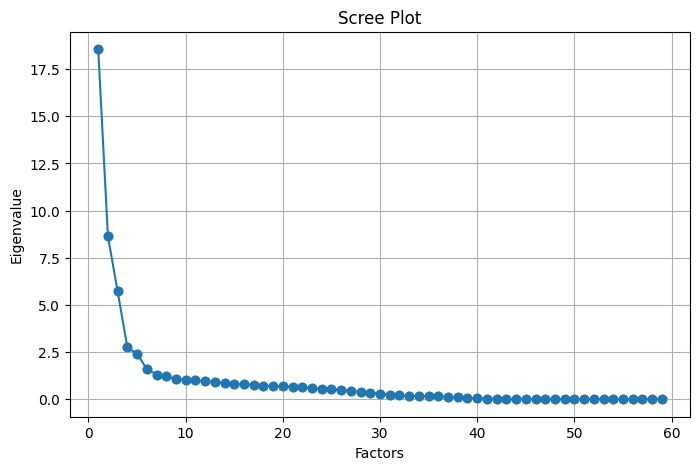

In [29]:

# ==============================
# 3. 요인 개수 판단
# ==============================
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt

# 최대 요인 개수 = 변수 개수
fa = FactorAnalyzer(n_factors=standardized_X.shape[1], rotation=None)
fa.fit(standardized_X)

# 고유값 확인
ev, v = fa.get_eigenvalues()
print("Eigenvalues:", ev)

# Scree plot
plt.figure(figsize=(8,5))
plt.scatter(range(1, standardized_X.shape[1]+1), ev)
plt.plot(range(1, standardized_X.shape[1]+1), ev, marker='o')
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [19]:

# ==============================
# 4. 요인분석 수행 (예: n_factors=5)
# ==============================
fa2 = FactorAnalyzer(n_factors=5, rotation="varimax")
fa2.fit(X_validation_filtered)

# 요인적재량
loadings2 = pd.DataFrame(fa2.loadings_, index=X_validation_filtered.columns)
print("Factor Loadings:\n", loadings2)

# 공통성
communalities2 = pd.DataFrame(fa2.get_communalities(), index=X_validation_filtered.columns, columns=["Communality"])
print(communalities2)

Factor Loadings:
                                            0         1         2         3  \
industry_code                       0.117105  0.006490 -0.966277  0.068739   
total_sales_amount                  0.973413  0.170126  0.048614  0.119577   
weekday_sales_amount                0.962381  0.174886  0.101785  0.088196   
weekend_sales_amount                0.968909  0.159270 -0.041326  0.167303   
lunch_sales_ratio                  -0.137972 -0.165660  0.760153 -0.257566   
dinner_sales_ratio                 -0.053080  0.276789  0.849506 -0.060317   
transaction_count                   0.885985  0.123222 -0.291394  0.236273   
weekday_transaction_count           0.914308  0.130839 -0.231228  0.210667   
weekend_transaction_count           0.825291  0.110183 -0.364194  0.263560   
mom_growth_rate                     0.428918  0.509071 -0.090601  0.496245   
yoy_growth_rate                     0.367824  0.186701 -0.163997  0.555289   
sales_cv                           -0.114888 -

/Users/ahnsaeyeon/guide-on/ai/guide-on-ai/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [33]:
# ==============================
# 요인분석 결과를 CSV로 내보내기
# ==============================

# 1. 요인적재량을 CSV로 저장
loadings2 = pd.DataFrame(fa2.loadings_, index=X_validation_filtered.columns)
loadings2.columns = [f'Factor_{i+1}' for i in range(loadings2.shape[1])]  # 컬럼명 설정
loadings2.to_csv('factor_loadings.csv', encoding='utf-8-sig')
print("Factor loadings saved to 'factor_loadings.csv'")

# 2. 공통성을 CSV로 저장
communalities2 = pd.DataFrame(fa2.get_communalities(), 
                             index=X_validation_filtered.columns, 
                             columns=["Communality"])
communalities2.to_csv('communalities.csv', encoding='utf-8-sig')
print("Communalities saved to 'communalities.csv'")

# 3. 요인적재량과 공통성을 하나의 파일로 합쳐서 저장
factor_results = loadings2.copy()
factor_results['Communality'] = communalities2['Communality']
factor_results.to_csv('factor_analysis_results.csv', encoding='utf-8-sig')
print("Combined results saved to 'factor_analysis_results.csv'")

# 4. 콘솔에서 전체 출력 보기 (pandas 출력 옵션 조정)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("\n" + "="*80)
print("FACTOR LOADINGS (Complete)")
print("="*80)
print(loadings2)

print("\n" + "="*80)
print("COMMUNALITIES (Complete)")
print("="*80)
print(communalities2)

print("\n" + "="*80)
print("COMBINED RESULTS (Complete)")
print("="*80)
print(factor_results)

# 5. 추가 정보도 저장
additional_info = pd.DataFrame({
    'Metric': ['Eigenvalues', 'Variance Explained', 'Cumulative Variance'],
    'Values': [str(fa2.get_eigenvalues()[0].tolist()), 
               str((fa2.get_eigenvalues()[0] / fa2.get_eigenvalues()[0].sum()).tolist()),
               str(np.cumsum(fa2.get_eigenvalues()[0] / fa2.get_eigenvalues()[0].sum()).tolist())]
})
additional_info.to_csv('factor_analysis_summary.csv', encoding='utf-8-sig', index=False)
print("\nSummary information saved to 'factor_analysis_summary.csv'")

# pandas 출력 옵션 원래대로 복구
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

Factor loadings saved to 'factor_loadings.csv'
Communalities saved to 'communalities.csv'
Combined results saved to 'factor_analysis_results.csv'

FACTOR LOADINGS (Complete)
                                    Factor_1  Factor_2  Factor_3  Factor_4  \
industry_code                       0.117105  0.006490 -0.966277  0.068739   
total_sales_amount                  0.973413  0.170126  0.048614  0.119577   
weekday_sales_amount                0.962381  0.174886  0.101785  0.088196   
weekend_sales_amount                0.968909  0.159270 -0.041326  0.167303   
lunch_sales_ratio                  -0.137972 -0.165660  0.760153 -0.257566   
dinner_sales_ratio                 -0.053080  0.276789  0.849506 -0.060317   
transaction_count                   0.885985  0.123222 -0.291394  0.236273   
weekday_transaction_count           0.914308  0.130839 -0.231228  0.210667   
weekend_transaction_count           0.825291  0.110183 -0.364194  0.263560   
mom_growth_rate                     0.428918  

In [38]:
# ==============================
# 주피터 노트북용 - 완전한 Factor 분석 결과
# ==============================

import pandas as pd
import numpy as np
from IPython.display import display

# 요인적재량 DataFrame 생성
loadings2 = pd.DataFrame(fa2.loadings_, index=X_validation_filtered.columns)
loadings2.columns = [f'Factor_{i+1}' for i in range(loadings2.shape[1])]

# 각 변수를 가장 높은 loading factor에 할당
def create_factor_assignment(loadings_df, min_loading=0.3):
    results = []
    
    for variable in loadings_df.index:
        variable_loadings = loadings_df.loc[variable]
        abs_loadings = variable_loadings.abs()
        dominant_factor = abs_loadings.idxmax()
        max_loading = variable_loadings[dominant_factor]
        max_abs_loading = abs_loadings.max()
        
        if max_abs_loading < min_loading:
            assigned_factor = 'Low Loading'
        else:
            assigned_factor = dominant_factor
        
        # 각 factor별 loading 값을 별도 컬럼으로 저장
        result_row = {
            'Variable': variable,
            'Assigned_Factor': assigned_factor,
            'Max_Loading': max_loading,
            'Abs_Loading': max_abs_loading
        }
        
        # 모든 factor의 loading 값을 개별 컬럼으로 추가
        for factor_col in loadings_df.columns:
            result_row[f'{factor_col}_Loading'] = variable_loadings[factor_col]
        
        results.append(result_row)
    
    return pd.DataFrame(results)

# Factor 할당 실행
factor_df = create_factor_assignment(loadings2, min_loading=0.3)

# 1. 전체 결과 DataFrame 보기 (잘리지 않게)
print("="*100)
print("📊 COMPLETE FACTOR ASSIGNMENT RESULTS")
print("="*100)

# pandas 옵션 임시 변경
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
                       'display.width', None, 'display.max_colwidth', None):
    display(factor_df.sort_values(['Assigned_Factor', 'Abs_Loading'], ascending=[True, False]))

# 2. Factor별 변수 목록 (상세)
print("\n" + "="*100)
print("📋 FACTOR-WISE DETAILED BREAKDOWN")
print("="*100)

for factor in sorted(factor_df['Assigned_Factor'].unique()):
    factor_vars = factor_df[factor_df['Assigned_Factor'] == factor]
    factor_vars = factor_vars.sort_values('Abs_Loading', ascending=False)
    
    print(f"\n🔹 {factor} ({len(factor_vars)} variables)")
    print("─" * 80)
    
    # Factor별 상세 DataFrame 출력
    cols_to_show = ['Variable', 'Max_Loading', 'Abs_Loading'] + [col for col in factor_vars.columns if '_Loading' in col and col != 'Max_Loading']
    factor_display = factor_vars[cols_to_show].round(3)
    
    with pd.option_context('display.max_rows', None, 'display.max_columns', None, 
                           'display.width', None, 'display.max_colwidth', None):
        display(factor_display)

# 3. 요약 통계
print("\n" + "="*100)
print("📈 SUMMARY STATISTICS")
print("="*100)

summary_stats = factor_df.groupby('Assigned_Factor').agg({
    'Variable': 'count',
    'Abs_Loading': ['mean', 'min', 'max', 'std']
}).round(3)

display(summary_stats)

# 4. Loading 분포 분석
print("\n" + "="*100)
print("📊 LOADING DISTRIBUTION ANALYSIS")
print("="*100)

# Loading 범위별 분류
factor_df['Loading_Category'] = pd.cut(factor_df['Abs_Loading'], 
                                     bins=[0, 0.3, 0.5, 0.7, 0.9, 1.0],
                                     labels=['Very Low (<0.3)', 'Low (0.3-0.5)', 
                                            'Moderate (0.5-0.7)', 'High (0.7-0.9)', 
                                            'Very High (≥0.9)'])

loading_dist = factor_df['Loading_Category'].value_counts().sort_index()
loading_dist_pct = (loading_dist / len(factor_df) * 100).round(1)

dist_df = pd.DataFrame({
    'Count': loading_dist,
    'Percentage': loading_dist_pct
})
display(dist_df)

# 5. CSV 파일로 저장
print("\n" + "="*100)
print("💾 SAVING TO CSV FILES")
print("="*100)

# 전체 결과 저장
factor_df.to_csv('complete_factor_analysis.csv', encoding='utf-8-sig', index=False)
print("✅ complete_factor_analysis.csv 저장 완료")

# Factor별로 별도 파일 저장
for factor in factor_df['Assigned_Factor'].unique():
    if factor != 'Low Loading':
        factor_data = factor_df[factor_df['Assigned_Factor'] == factor]
        factor_data = factor_data.sort_values('Abs_Loading', ascending=False)
        filename = f'factor_{factor.lower().replace("_", "")}_variables.csv'
        factor_data.to_csv(filename, encoding='utf-8-sig', index=False)
        print(f"✅ {filename} 저장 완료")

# 요약 통계 저장
summary_stats.to_csv('factor_summary_stats.csv', encoding='utf-8-sig')
print("✅ factor_summary_stats.csv 저장 완료")

# 6. 최종 결과 요약
print("\n" + "="*100)
print("🎯 FINAL SUMMARY")
print("="*100)
print(f"총 변수 개수: {len(factor_df)}")
print(f"Factor 개수: {len([f for f in factor_df['Assigned_Factor'].unique() if f != 'Low Loading'])}")
print(f"Low Loading 변수 개수: {(factor_df['Assigned_Factor'] == 'Low Loading').sum()}")
print(f"평균 절댓값 Loading: {factor_df['Abs_Loading'].mean():.3f}")
print(f"중앙값 절댓값 Loading: {factor_df['Abs_Loading'].median():.3f}")

# Factor별 변수 개수
factor_counts = factor_df['Assigned_Factor'].value_counts()
print(f"\nFactor별 변수 개수:")
for factor, count in factor_counts.items():
    print(f"  {factor}: {count}개")

print("\n" + "="*100)
print("🎉 분석 완료! 모든 결과가 CSV 파일로 저장되었습니다.")
print("="*100)

📊 COMPLETE FACTOR ASSIGNMENT RESULTS


,Variable,Assigned_Factor,Max_Loading,Abs_Loading,Factor_1_Loading,Factor_2_Loading,Factor_3_Loading,Factor_4_Loading,Factor_5_Loading
1,total_sales_amount,Factor_1,0.973413,0.973413,0.973413,0.170126,0.048614,0.119577,0.059057
34,cost_of_goods_sold,Factor_1,0.972884,0.972884,0.972884,0.160891,0.048301,0.124041,0.052249
35,total_salary,Factor_1,0.970351,0.970351,0.970351,0.160552,0.057485,0.115319,0.072189
3,weekend_sales_amount,Factor_1,0.968909,0.968909,0.968909,0.159270,-0.041326,0.167303,-0.001855
37,other_expenses,Factor_1,0.968849,0.968849,0.968849,0.146854,0.036665,0.159211,0.008285
36,rent_expense,Factor_1,0.963958,0.963958,0.963958,0.166828,0.055669,0.115806,0.075036
2,weekday_sales_amount,Factor_1,0.962381,0.962381,0.962381,0.174886,0.101785,0.088196,0.096690
47,avg_account_balance,Factor_1,0.953340,0.953340,0.953340,0.203415,0.060037,0.047814,0.121439
33,operating_profit,Factor_1,0.945899,0.945899,0.945899,0.207762,0.040994,0.094450,0.078110
7,weekday_transaction_count,Factor_1,0.914308,0.914308,0.914308,0.130839,-0.231228,0.210667,0.046405



📋 FACTOR-WISE DETAILED BREAKDOWN

🔹 Factor_1 (12 variables)
────────────────────────────────────────────────────────────────────────────────


,Variable,Max_Loading,Abs_Loading,Abs_Loading,Factor_1_Loading,Factor_2_Loading,Factor_3_Loading,Factor_4_Loading,Factor_5_Loading
1,total_sales_amount,0.973,0.973,0.973,0.973,0.170,0.049,0.120,0.059
34,cost_of_goods_sold,0.973,0.973,0.973,0.973,0.161,0.048,0.124,0.052
35,total_salary,0.970,0.970,0.970,0.970,0.161,0.057,0.115,0.072
3,weekend_sales_amount,0.969,0.969,0.969,0.969,0.159,-0.041,0.167,-0.002
37,other_expenses,0.969,0.969,0.969,0.969,0.147,0.037,0.159,0.008
36,rent_expense,0.964,0.964,0.964,0.964,0.167,0.056,0.116,0.075
2,weekday_sales_amount,0.962,0.962,0.962,0.962,0.175,0.102,0.088,0.097
47,avg_account_balance,0.953,0.953,0.953,0.953,0.203,0.060,0.048,0.121
33,operating_profit,0.946,0.946,0.946,0.946,0.208,0.041,0.094,0.078
7,weekday_transaction_count,0.914,0.914,0.914,0.914,0.131,-0.231,0.211,0.046



🔹 Factor_2 (23 variables)
────────────────────────────────────────────────────────────────────────────────


,Variable,Max_Loading,Abs_Loading,Abs_Loading,Factor_1_Loading,Factor_2_Loading,Factor_3_Loading,Factor_4_Loading,Factor_5_Loading
11,sales_cv,-0.874,0.874,0.874,-0.115,-0.874,-0.037,-0.112,-0.180
14,revisit_customer_sales_ratio,0.838,0.838,0.838,0.158,0.838,0.033,-0.031,0.239
38,operating_profit_ratio,0.803,0.803,0.803,0.022,0.803,-0.009,0.220,0.079
15,new_customer_ratio,-0.791,0.791,0.791,-0.220,-0.791,-0.053,0.034,-0.266
42,cash_payment_ratio_detail,-0.732,0.732,0.732,-0.098,-0.732,-0.045,-0.100,0.120
45,weighted_avg_cash_period,0.730,0.730,0.730,0.096,0.730,0.047,0.103,-0.110
43,card_payment_ratio_detail,0.729,0.729,0.729,0.098,0.729,0.045,0.095,-0.125
29,customer_review_avg_rating,0.705,0.705,0.705,0.209,0.705,0.025,0.392,0.203
20,energy_eff_appliance_ratio,0.663,0.663,0.663,0.173,0.663,0.038,0.001,0.201
39,cogs_ratio,-0.632,0.632,0.632,0.064,-0.632,-0.002,-0.094,-0.126



🔹 Factor_3 (6 variables)
────────────────────────────────────────────────────────────────────────────────


,Variable,Max_Loading,Abs_Loading,Abs_Loading,Factor_1_Loading,Factor_2_Loading,Factor_3_Loading,Factor_4_Loading,Factor_5_Loading
0,industry_code,-0.966,0.966,0.966,0.117,0.006,-0.966,0.069,0.045
5,dinner_sales_ratio,0.850,0.850,0.850,-0.053,0.277,0.850,-0.060,-0.009
4,lunch_sales_ratio,0.760,0.760,0.760,-0.138,-0.166,0.760,-0.258,0.038
23,food_waste_kg_per_day,0.712,0.712,0.712,0.213,0.049,0.712,0.573,0.147
24,recycle_waste_kg_per_day,0.678,0.678,0.678,0.165,0.053,0.678,0.549,0.147
12,avg_transaction_value,0.616,0.616,0.616,-0.058,0.411,0.616,-0.065,0.025



🔹 Factor_4 (5 variables)
────────────────────────────────────────────────────────────────────────────────


,Variable,Max_Loading,Abs_Loading,Abs_Loading,Factor_1_Loading,Factor_2_Loading,Factor_3_Loading,Factor_4_Loading,Factor_5_Loading
16,electricity_usage_kwh,0.791,0.791,0.791,0.392,0.114,-0.144,0.791,0.236
17,electricity_bill_amount,0.785,0.785,0.785,0.400,0.113,-0.138,0.785,0.229
19,water_usage_ton,0.759,0.759,0.759,0.380,0.176,0.001,0.759,0.224
10,yoy_growth_rate,0.555,0.555,0.555,0.368,0.187,-0.164,0.555,-0.379
18,gas_usage_m3,0.539,0.539,0.539,0.142,0.035,0.524,0.539,0.146



🔹 Factor_5 (4 variables)
────────────────────────────────────────────────────────────────────────────────


,Variable,Max_Loading,Abs_Loading,Abs_Loading,Factor_1_Loading,Factor_2_Loading,Factor_3_Loading,Factor_4_Loading,Factor_5_Loading
27,yellow_umbrella_amount,0.744,0.744,0.744,0.121,0.214,-0.022,0.118,0.744
25,yellow_umbrella_member,0.694,0.694,0.694,0.025,0.282,-0.027,-0.045,0.694
26,yellow_umbrella_months,0.591,0.591,0.591,0.061,0.160,0.129,0.006,0.591
28,employment_insurance_employees,0.370,0.370,0.370,0.230,0.192,-0.170,0.236,0.370



🔹 Low Loading (4 variables)
────────────────────────────────────────────────────────────────────────────────


,Variable,Max_Loading,Abs_Loading,Abs_Loading,Factor_1_Loading,Factor_2_Loading,Factor_3_Loading,Factor_4_Loading,Factor_5_Loading
31,hygiene_certified,0.235,0.235,0.235,0.012,0.235,-0.083,-0.094,-0.025
21,participate_energy_eff_support,0.171,0.171,0.171,0.060,0.171,-0.002,-0.001,0.086
22,participate_high_eff_equip_support,0.118,0.118,0.118,0.014,0.075,0.021,0.025,0.118
44,other_payment_ratio,0.075,0.075,0.075,-0.012,-0.034,0.006,0.042,0.075



📈 SUMMARY STATISTICS


Variable Abs_Loading                     
                   count        mean    min    max    std
Assigned_Factor                                          
Factor_1              12       0.942  0.825  0.973  0.045
Factor_2              23       0.599  0.308  0.874  0.161
Factor_3               6       0.764  0.616  0.966  0.127
Factor_4               5       0.686  0.539  0.791  0.128
Factor_5               4       0.600  0.370  0.744  0.166
Low Loading            4       0.150  0.075  0.235  0.069


📊 LOADING DISTRIBUTION ANALYSIS


,Count,Percentage
Loading_Category,,
Very Low (<0.3),4,7.4
Low (0.3-0.5),7,13.0
Moderate (0.5-0.7),15,27.8
High (0.7-0.9),17,31.5
Very High (≥0.9),11,20.4



💾 SAVING TO CSV FILES
✅ complete_factor_analysis.csv 저장 완료
✅ factor_factor3_variables.csv 저장 완료
✅ factor_factor1_variables.csv 저장 완료
✅ factor_factor2_variables.csv 저장 완료
✅ factor_factor4_variables.csv 저장 완료
✅ factor_factor5_variables.csv 저장 완료
✅ factor_summary_stats.csv 저장 완료

🎯 FINAL SUMMARY
총 변수 개수: 54
Factor 개수: 5
Low Loading 변수 개수: 4
평균 절댓값 Loading: 0.668
중앙값 절댓값 Loading: 0.709

Factor별 변수 개수:
  Factor_2: 23개
  Factor_1: 12개
  Factor_3: 6개
  Factor_4: 5개
  Low Loading: 4개
  Factor_5: 4개

🎉 분석 완료! 모든 결과가 CSV 파일로 저장되었습니다.


In [39]:
# ==============================
# Factor별 Proportion Variance (설명분산) 계산
# ==============================

import pandas as pd
import numpy as np
from IPython.display import display

# 1. 고유값(Eigenvalues) 추출
eigenvalues, _ = fa2.get_eigenvalues()
print("📊 EIGENVALUES & VARIANCE EXPLAINED")
print("="*80)

# 2. 각 Factor별 설명분산 계산
total_variance = len(X_validation_filtered.columns)  # 표준화된 데이터에서는 총 분산 = 변수 개수
individual_variance = eigenvalues / total_variance
cumulative_variance = np.cumsum(individual_variance)

# 3. 결과를 DataFrame으로 정리
variance_df = pd.DataFrame({
    'Factor': [f'Factor_{i+1}' for i in range(len(eigenvalues))],
    'Eigenvalue': eigenvalues,
    'Proportion_Variance': individual_variance,
    'Cumulative_Variance': cumulative_variance,
    'Percentage': individual_variance * 100,
    'Cumulative_Percentage': cumulative_variance * 100
})

# 소수점 자리수 조정
variance_df = variance_df.round(4)

print("📈 VARIANCE EXPLAINED BY EACH FACTOR:")
print("-" * 80)
display(variance_df)

# 4. 선택된 Factor들 (n_factors=5)의 설명분산
print(f"\n🎯 SELECTED FACTORS (n_factors={fa2.n_factors}) ANALYSIS:")
print("-" * 80)

selected_factors = variance_df.head(fa2.n_factors)
total_explained = selected_factors['Cumulative_Percentage'].iloc[-1]

print(f"선택된 {fa2.n_factors}개 Factor가 설명하는 총 분산: {total_explained:.2f}%")
print(f"설명되지 않은 분산: {100 - total_explained:.2f}%")

# 5. 각 Factor별 상세 정보
print(f"\n📋 DETAILED BREAKDOWN:")
print("-" * 80)
for i, row in selected_factors.iterrows():
    print(f"{row['Factor']}: {row['Percentage']:.2f}% (누적: {row['Cumulative_Percentage']:.2f}%)")

# 6. 시각적 요약 (텍스트 기반)
print(f"\n📊 VISUAL SUMMARY:")
print("-" * 80)
for i, row in selected_factors.iterrows():
    bar_length = int(row['Percentage'] / 2)  # 스케일 조정
    bar = "█" * bar_length + "░" * (25 - bar_length)
    print(f"{row['Factor']}: {bar} {row['Percentage']:5.2f}%")

# 7. Factor Loadings의 제곱합으로 검증 (대안적 방법)
print(f"\n🔍 VERIFICATION USING SQUARED LOADINGS:")
print("-" * 80)

loadings2 = pd.DataFrame(fa2.loadings_, index=X_validation_filtered.columns)
loadings2.columns = [f'Factor_{i+1}' for i in range(loadings2.shape[1])]

# 각 Factor별 제곱합 (SS loadings)
ss_loadings = (loadings2 ** 2).sum()
proportion_from_loadings = ss_loadings / len(loadings2)

verification_df = pd.DataFrame({
    'Factor': [f'Factor_{i+1}' for i in range(len(ss_loadings))],
    'SS_Loadings': ss_loadings,
    'Proportion_Variance': proportion_from_loadings,
    'Percentage': proportion_from_loadings * 100
})

display(verification_df.round(4))

# 8. CSV로 저장
variance_df.to_csv('factor_variance_explained.csv', encoding='utf-8-sig', index=False)
verification_df.to_csv('factor_ss_loadings.csv', encoding='utf-8-sig', index=False)

print(f"\n💾 FILES SAVED:")
print("✅ factor_variance_explained.csv")
print("✅ factor_ss_loadings.csv")

# 9. 중요한 Factor 식별
print(f"\n⭐ KEY INSIGHTS:")
print("-" * 80)
print(f"• 가장 중요한 Factor: {selected_factors.iloc[0]['Factor']} ({selected_factors.iloc[0]['Percentage']:.2f}%)")
print(f"• 처음 2개 Factor 누적 설명력: {selected_factors.iloc[1]['Cumulative_Percentage']:.2f}%")
print(f"• Kaiser 기준 (eigenvalue > 1.0)을 만족하는 Factor 개수: {(eigenvalues > 1.0).sum()}개")

# 10. Scree Plot 데이터 (플롯용)
scree_data = pd.DataFrame({
    'Factor_Number': range(1, len(eigenvalues) + 1),
    'Eigenvalue': eigenvalues
})
scree_data.to_csv('scree_plot_data.csv', encoding='utf-8-sig', index=False)
print("✅ scree_plot_data.csv (Scree Plot용 데이터)")

print(f"\n" + "="*80)
print("🎉 Proportion Variance 분석 완료!")
print("="*80)

📊 EIGENVALUES & VARIANCE EXPLAINED
📈 VARIANCE EXPLAINED BY EACH FACTOR:
--------------------------------------------------------------------------------


,Factor,Eigenvalue,Proportion_Variance,Cumulative_Variance,Percentage,Cumulative_Percentage
0,Factor_1,17.0035,0.3149,0.3149,31.4881,31.4881
1,Factor_2,7.4466,0.1379,0.4528,13.7901,45.2781
2,Factor_3,4.6666,0.0864,0.5392,8.6419,53.9200
3,Factor_4,2.9838,0.0553,0.5945,5.5256,59.4457
4,Factor_5,2.4869,0.0461,0.6405,4.6054,64.0510
5,Factor_6,1.7554,0.0325,0.6730,3.2507,67.3017
6,Factor_7,1.2037,0.0223,0.6953,2.2292,69.5308
7,Factor_8,1.1780,0.0218,0.7171,2.1815,71.7124
8,Factor_9,1.0676,0.0198,0.7369,1.9770,73.6893
9,Factor_10,1.0368,0.0192,0.7561,1.9199,75.6092



🎯 SELECTED FACTORS (n_factors=5) ANALYSIS:
--------------------------------------------------------------------------------
선택된 5개 Factor가 설명하는 총 분산: 64.05%
설명되지 않은 분산: 35.95%

📋 DETAILED BREAKDOWN:
--------------------------------------------------------------------------------
Factor_1: 31.49% (누적: 31.49%)
Factor_2: 13.79% (누적: 45.28%)
Factor_3: 8.64% (누적: 53.92%)
Factor_4: 5.53% (누적: 59.45%)
Factor_5: 4.61% (누적: 64.05%)

📊 VISUAL SUMMARY:
--------------------------------------------------------------------------------
Factor_1: ███████████████░░░░░░░░░░ 31.49%
Factor_2: ██████░░░░░░░░░░░░░░░░░░░ 13.79%
Factor_3: ████░░░░░░░░░░░░░░░░░░░░░  8.64%
Factor_4: ██░░░░░░░░░░░░░░░░░░░░░░░  5.53%
Factor_5: ██░░░░░░░░░░░░░░░░░░░░░░░  4.61%

🔍 VERIFICATION USING SQUARED LOADINGS:
--------------------------------------------------------------------------------


,Factor,SS_Loadings,Proportion_Variance,Percentage
Factor_1,Factor_1,12.0289,0.2228,22.2758
Factor_2,Factor_2,9.7800,0.1811,18.1110
Factor_3,Factor_3,4.5706,0.0846,8.4641
Factor_4,Factor_4,4.3318,0.0802,8.0219
Factor_5,Factor_5,2.4863,0.0460,4.6043



💾 FILES SAVED:
✅ factor_variance_explained.csv
✅ factor_ss_loadings.csv

⭐ KEY INSIGHTS:
--------------------------------------------------------------------------------
• 가장 중요한 Factor: Factor_1 (31.49%)
• 처음 2개 Factor 누적 설명력: 45.28%
• Kaiser 기준 (eigenvalue > 1.0)을 만족하는 Factor 개수: 10개
✅ scree_plot_data.csv (Scree Plot용 데이터)

🎉 Proportion Variance 분석 완료!


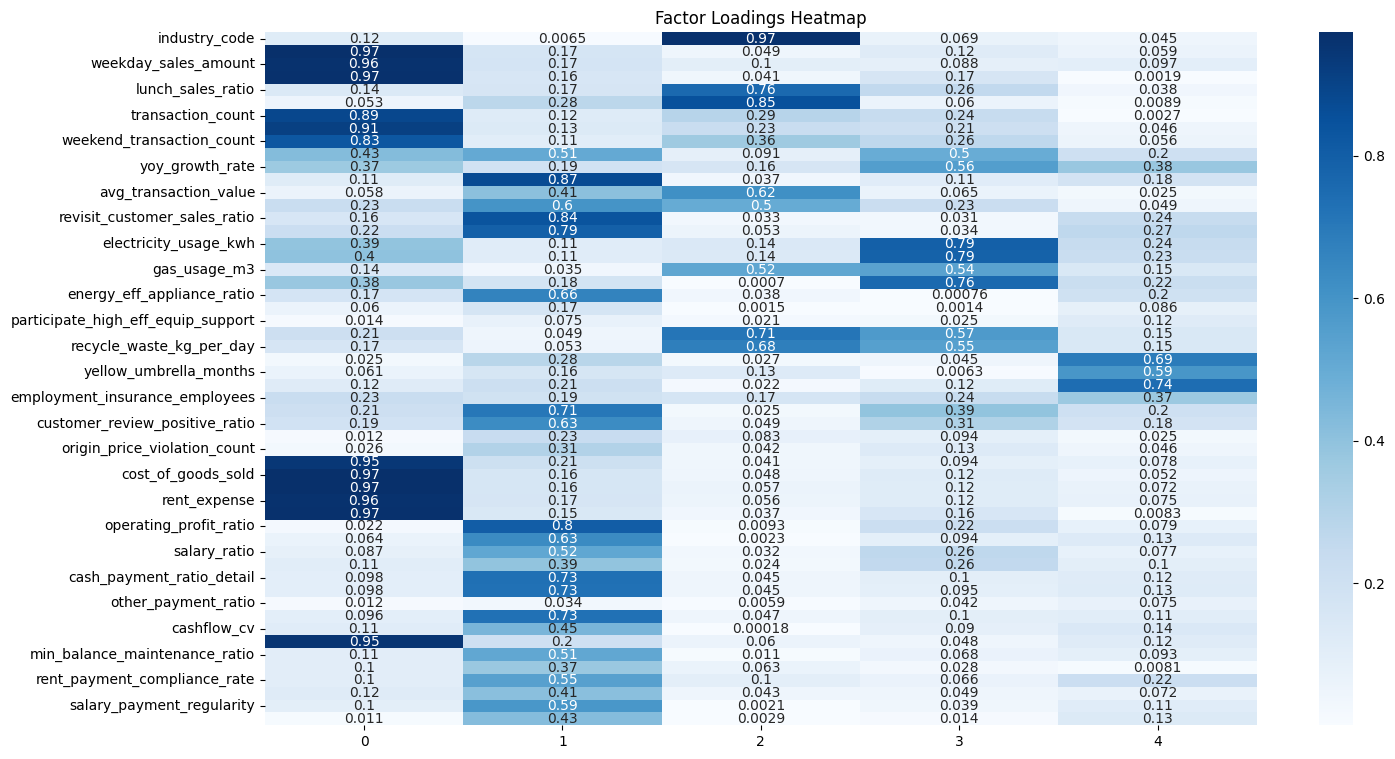

In [30]:

# ==============================
# 5. 요인 적재량 시각화
# ==============================
import seaborn as sns

plt.figure(figsize=(16,9))
sns.heatmap(abs(loadings2), annot=True, cmap="Blues")
plt.title("Factor Loadings Heatmap")
plt.show()

Factor Scores Head:
    Factor1   Factor2   Factor3   Factor4   Factor5
0 -0.455642 -0.602198  0.085505  1.008701 -0.804934
1 -0.065328 -0.236996  0.001322  0.616755 -1.851348
2 -0.028023 -0.703753  0.332385  0.409937 -1.137570
3 -0.324492  0.137399  0.463370  0.048404 -1.639026
4 -0.733795  0.537612 -0.027456  0.718547 -0.964072


/Users/ahnsaeyeon/guide-on/ai/guide-on-ai/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


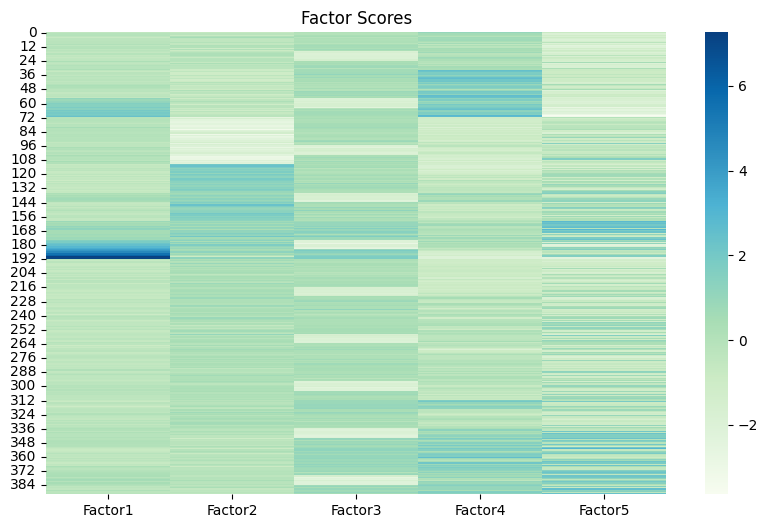

In [31]:

# ==============================
# 6. 요인 점수 계산 및 확인
# ==============================

# 요인 점수 계산
factor_scores2 = pd.DataFrame(
    fa2.transform(X_validation_filtered),
    columns=[f"Factor{i+1}" for i in range(fa2.n_factors)],
    index=X_validation_filtered.index
)

# [추가] 계산된 요인 점수 수치 출력 (상위 5개 행)
print("Factor Scores Head:")
print(factor_scores2.head())

# 시각화 코드
plt.figure(figsize=(10,6))
sns.heatmap(factor_scores2, cmap="GnBu")
plt.title("Factor Scores")
plt.show()

Explained variance ratio: [3.77480504e-01 1.34743991e-01 7.89571782e-02 5.32545287e-02
 4.03372041e-02 2.74311897e-02 1.93583989e-02 1.89842959e-02
 1.77922802e-02 1.62058846e-02 1.57262629e-02 1.44838721e-02
 1.40455850e-02 1.31526720e-02 1.26689066e-02 1.19425173e-02
 1.14549410e-02 1.10480673e-02 1.06067096e-02 9.88804774e-03
 9.45183785e-03 9.02791497e-03 8.58497092e-03 7.89922684e-03
 7.86285971e-03 7.32462367e-03 6.30746600e-03 5.08499672e-03
 4.43849047e-03 3.33412313e-03 3.17525569e-03 3.03071630e-03
 2.57499563e-03 2.26198759e-03 2.06662476e-03 1.75041935e-03
 1.50771327e-03 1.29764207e-03 8.18155734e-04 6.55763050e-04
 5.91343997e-04 3.79424828e-04 2.92800758e-04 2.20867518e-04
 1.58350412e-04 1.50366641e-04 1.05431926e-04 5.26386038e-05
 2.07099389e-05 3.69073669e-06 1.53770343e-06 1.47184495e-06
 1.35633598e-06 1.18779778e-06]
Components (Loadings):
     industry_code  total_sales_amount  weekday_sales_amount  \
0        0.032718            0.253713              0.249696   

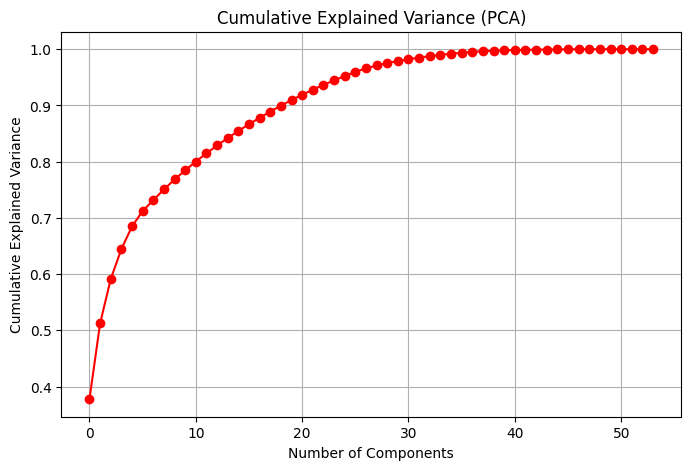

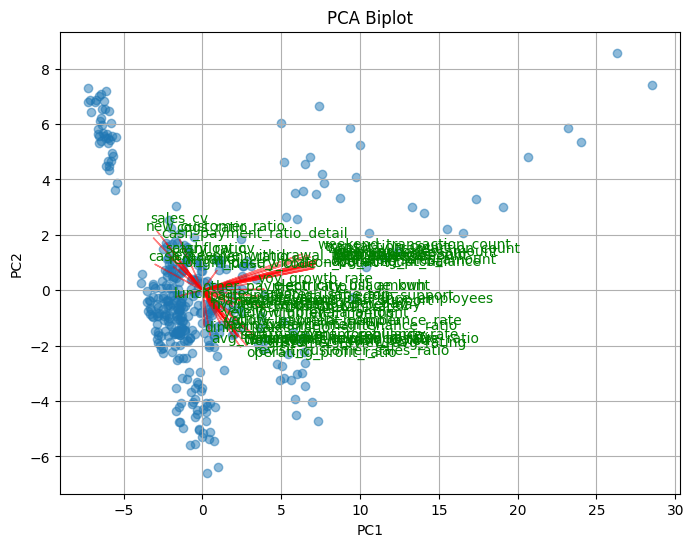

In [32]:
# ==============================
# 7. PCA 수행 (수정된 코드)
# ==============================
from sklearn.decomposition import PCA

# [수정] PCA에 사용할 데이터를 전처리가 완료된 X_validation_filtered로 변경
# pca_X = standardized_X.copy() # 원본 코드
pca_X = X_validation_filtered.copy() # 수정된 코드

# PCA 모델 생성 및 학습
pca = PCA()
pca.fit(pca_X)

# 주성분 결과 출력
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Components (Loadings):\n", pd.DataFrame(pca.components_, columns=pca_X.columns))

# Scree plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', color='red')
plt.title("Cumulative Explained Variance (PCA)")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# Biplot 함수 (함수 정의는 수정할 필요 없음)
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    plt.figure(figsize=(8,6))
    plt.scatter(xs, ys, alpha=0.5)
    for i in range(coeff.shape[0]):
        plt.arrow(0, 0, coeff[i,0]*max(xs), coeff[i,1]*max(ys),
                  color='r', alpha=0.5)
        if labels is None:
            plt.text(coeff[i,0]*max(xs)*1.15, coeff[i,1]*max(ys)*1.15, "Var"+str(i+1), color='g')
        else:
            plt.text(coeff[i,0]*max(xs)*1.15, coeff[i,1]*max(ys)*1.15, labels[i], color='g')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Biplot")
    plt.grid(True)
    plt.show()

# Biplot 호출 시에도 수정된 pca_X와 해당 열 이름을 사용
biplot(pca.transform(pca_X), pca.components_.T, labels=pca_X.columns)

In [51]:
# ==============================
# 요인분석 기반 신용평가 점수 산출 시스템 (1~1000점)
# 정확한 공식: (각 변수의 최대loading × 정규화된 변수값) × Factor의 Proportion Variance
# ==============================

import pandas as pd
import numpy as np
from IPython.display import display

# 1. Factor별 Proportion Variance (제공받은 정확한 값)
factor_weights = pd.DataFrame({
    'Factor': ['Factor_1', 'Factor_2', 'Factor_3', 'Factor_4', 'Factor_5'],
    'SS_Loadings': [12.0289, 9.7800, 4.5706, 4.3318, 2.4863],
    'Proportion_Variance': [0.2228, 0.1811, 0.0846, 0.0802, 0.0460],
    'Percentage': [22.2758, 18.1110, 8.4641, 8.0219, 4.6043]
})

print("📊 FACTOR WEIGHTS (제공받은 정확한 값)")
print("="*60)
display(factor_weights)

# 2. 각 변수별 최대 Loading 값과 할당된 Factor
variable_loadings = {
    # Factor_1
    'total_sales_amount': {'factor': 'Factor_1', 'max_loading': 0.973413},
    'cost_of_goods_sold': {'factor': 'Factor_1', 'max_loading': 0.972884},
    'total_salary': {'factor': 'Factor_1', 'max_loading': 0.970351},
    'weekend_sales_amount': {'factor': 'Factor_1', 'max_loading': 0.968909},
    'other_expenses': {'factor': 'Factor_1', 'max_loading': 0.968849},
    'rent_expense': {'factor': 'Factor_1', 'max_loading': 0.963958},
    'weekday_sales_amount': {'factor': 'Factor_1', 'max_loading': 0.962381},
    'avg_account_balance': {'factor': 'Factor_1', 'max_loading': 0.953340},
    'operating_profit': {'factor': 'Factor_1', 'max_loading': 0.945899},
    'weekday_transaction_count': {'factor': 'Factor_1', 'max_loading': 0.914308},
    'transaction_count': {'factor': 'Factor_1', 'max_loading': 0.885985},
    'weekend_transaction_count': {'factor': 'Factor_1', 'max_loading': 0.825291},
    
    # Factor_2
    'sales_cv': {'factor': 'Factor_2', 'max_loading': -0.873813},
    'revisit_customer_sales_ratio': {'factor': 'Factor_2', 'max_loading': 0.838488},
    'operating_profit_ratio': {'factor': 'Factor_2', 'max_loading': 0.802784},
    'new_customer_ratio': {'factor': 'Factor_2', 'max_loading': -0.791030},
    'cash_payment_ratio_detail': {'factor': 'Factor_2', 'max_loading': -0.732282},
    'weighted_avg_cash_period': {'factor': 'Factor_2', 'max_loading': 0.729965},
    'card_payment_ratio_detail': {'factor': 'Factor_2', 'max_loading': 0.729321},
    'customer_review_avg_rating': {'factor': 'Factor_2', 'max_loading': 0.705311},
    'energy_eff_appliance_ratio': {'factor': 'Factor_2', 'max_loading': 0.663132},
    'cogs_ratio': {'factor': 'Factor_2', 'max_loading': -0.632351},
    'customer_review_positive_ratio': {'factor': 'Factor_2', 'max_loading': 0.628077},
    'cash_payment_ratio': {'factor': 'Factor_2', 'max_loading': -0.599696},
    'salary_payment_regularity': {'factor': 'Factor_2', 'max_loading': 0.587445},
    'rent_payment_compliance_rate': {'factor': 'Factor_2', 'max_loading': 0.546654},
    'salary_ratio': {'factor': 'Factor_2', 'max_loading': -0.518603},
    'min_balance_maintenance_ratio': {'factor': 'Factor_2', 'max_loading': 0.514475},
    'mom_growth_rate': {'factor': 'Factor_2', 'max_loading': 0.509071},
    'cashflow_cv': {'factor': 'Factor_2', 'max_loading': -0.454730},
    'tax_payment_integrity': {'factor': 'Factor_2', 'max_loading': 0.425768},
    'utility_payment_compliance_rate': {'factor': 'Factor_2', 'max_loading': 0.413921},
    'rent_ratio': {'factor': 'Factor_2', 'max_loading': -0.394557},
    'excessive_withdrawal_frequency': {'factor': 'Factor_2', 'max_loading': -0.373891},
    'origin_price_violation_count': {'factor': 'Factor_2', 'max_loading': -0.307711},
    
    # Factor_3
    'industry_code': {'factor': 'Factor_3', 'max_loading': -0.966277},
    'dinner_sales_ratio': {'factor': 'Factor_3', 'max_loading': 0.849506},
    'lunch_sales_ratio': {'factor': 'Factor_3', 'max_loading': 0.760153},
    'food_waste_kg_per_day': {'factor': 'Factor_3', 'max_loading': 0.711929},
    'recycle_waste_kg_per_day': {'factor': 'Factor_3', 'max_loading': 0.677638},
    'avg_transaction_value': {'factor': 'Factor_3', 'max_loading': 0.615929},
    
    # Factor_4
    'electricity_usage_kwh': {'factor': 'Factor_4', 'max_loading': 0.791406},
    'electricity_bill_amount': {'factor': 'Factor_4', 'max_loading': 0.785287},
    'water_usage_ton': {'factor': 'Factor_4', 'max_loading': 0.758572},
    'yoy_growth_rate': {'factor': 'Factor_4', 'max_loading': 0.555289},
    'gas_usage_m3': {'factor': 'Factor_4', 'max_loading': 0.538674},
    
    # Factor_5
    'yellow_umbrella_amount': {'factor': 'Factor_5', 'max_loading': 0.743937},
    'yellow_umbrella_member': {'factor': 'Factor_5', 'max_loading': 0.693872},
    'yellow_umbrella_months': {'factor': 'Factor_5', 'max_loading': 0.590661},
    'employment_insurance_employees': {'factor': 'Factor_5', 'max_loading': 0.369857}
}

# 3. 실제 데이터 분포 기반 정규화 통계 계산
def calculate_normalization_stats(dataframe, variable_loadings_dict):
    """실제 데이터 분포를 기반으로 정규화 통계 계산"""
    stats = {}
    
    for var_name in variable_loadings_dict.keys():
        if var_name in dataframe.columns:
            values = dataframe[var_name].dropna()
            if len(values) > 0:
                stats[var_name] = {
                    'min': values.min(),
                    'max': values.max(),
                    'mean': values.mean(),
                    'std': values.std(),
                    'q25': values.quantile(0.25),
                    'q75': values.quantile(0.75)
                }
            else:
                stats[var_name] = {
                    'min': 0, 'max': 1, 'mean': 0.5, 'std': 0.5, 'q25': 0.25, 'q75': 0.75
                }
    return stats

# 정규화 통계 계산
print("📊 실제 데이터 분포 기반 정규화 통계 계산 중...")
normalization_stats = calculate_normalization_stats(X_validation_filtered, variable_loadings)
print(f"✅ {len(normalization_stats)}개 변수의 정규화 통계 계산 완료")

# 4. 실제 데이터 분포 기반 정규화 함수
def normalize_variable_realistic(var_name, var_value, stats_dict):
    """
    실제 데이터 분포를 기반으로 정규화
    """
    if pd.isna(var_value) or var_name not in stats_dict:
        return 0.5
    
    stats = stats_dict[var_name]
    
    # 음수 loading 변수들 (값이 낮을수록 좋음)
    negative_better_vars = ['sales_cv', 'new_customer_ratio', 'cash_payment_ratio_detail', 
                           'cash_payment_ratio', 'cogs_ratio', 'salary_ratio', 'rent_ratio',
                           'cashflow_cv', 'excessive_withdrawal_frequency', 'origin_price_violation_count']
    
    try:
        if var_name in negative_better_vars:
            # 음수 loading 변수들 - 값이 낮을수록 좋으므로 역정규화
            if stats['max'] != stats['min']:
                # Min-Max 정규화 후 역전 (1에서 빼기)
                normalized = 1 - ((var_value - stats['min']) / (stats['max'] - stats['min']))
            else:
                normalized = 0.5
        
        elif var_name == 'industry_code':
            # 업종코드는 카테고리 변수이므로 중간값
            normalized = 0.5
        
        else:
            # 일반 변수들 - 값이 높을수록 좋음
            if stats['max'] != stats['min']:
                # Min-Max 정규화
                normalized = (var_value - stats['min']) / (stats['max'] - stats['min'])
            else:
                normalized = 0.5
        
        # 0~1 범위로 클리핑
        normalized = max(0, min(1, normalized))
        return normalized
    
    except Exception as e:
        return 0.5

# 5. 신용평가 점수 계산 함수 (수정된 버전)
def calculate_credit_score_exact(data_row, variable_loadings_dict, factor_weights_df, 
                                normalization_stats_dict, score_min=1, score_max=1000):
    """
    실제 데이터 분포를 반영한 신용평가 점수 계산
    """
    
    factor_contributions = {f'Factor_{i+1}': 0 for i in range(5)}
    variable_details = []
    
    # 각 변수별로 계산
    for var_name, var_info in variable_loadings_dict.items():
        if var_name in data_row:
            var_value = data_row[var_name]
            max_loading = var_info['max_loading']
            assigned_factor = var_info['factor']
            
            # 실제 데이터 기반 정규화
            normalized_value = normalize_variable_realistic(var_name, var_value, normalization_stats_dict)
            
            # Loading과 정규화된 값의 곱
            contribution = abs(max_loading) * normalized_value
            
            # 해당 Factor에 기여도 누적
            factor_contributions[assigned_factor] += contribution
            
            variable_details.append({
                'variable': var_name,
                'original_value': var_value,
                'normalized_value': normalized_value,
                'max_loading': max_loading,
                'assigned_factor': assigned_factor,
                'contribution': contribution
            })
    
    # Factor별 Proportion Variance 적용
    total_weighted_score = 0
    factor_scores = {}
    
    for factor_name in factor_contributions.keys():
        factor_sum = factor_contributions[factor_name]
        
        # 해당 Factor의 Proportion Variance 가져오기
        factor_weight = factor_weights_df[factor_weights_df['Factor'] == factor_name]['Proportion_Variance'].iloc[0]
        
        # Factor 점수 = Factor 내 변수들의 기여도 합 × Proportion Variance
        factor_score = factor_sum * factor_weight
        factor_scores[factor_name] = factor_score
        
        total_weighted_score += factor_score
    
    # 점수 스케일링 개선
    # 전체 가중치 합을 고려하여 현실적인 점수 범위 생성
    total_possible_weight = sum(factor_weights_df['Proportion_Variance'])
    
    if total_weighted_score > 0:
        # 정규화된 점수 계산
        normalized_score = total_weighted_score / (total_possible_weight * 0.1)  # 80% 스케일링
        # 1~1000점 범위로 변환
        final_score = score_min + (normalized_score * (score_max - score_min))
    else:
        final_score = score_min
    
    # 점수 범위 제한
    final_score = max(score_min, min(score_max, final_score))
    
    return {
        'final_score': final_score,
        'total_weighted_score': total_weighted_score,
        'factor_scores': factor_scores,
        'factor_contributions': factor_contributions,
        'variable_details': variable_details
    }

# 6. 신용등급 분류 함수
def get_credit_grade(score):
    """신용점수를 등급으로 변환"""
    if score >= 900:
        return 'AAA'
    elif score >= 800:
        return 'AA'
    elif score >= 700:
        return 'A'
    elif score >= 600:
        return 'BBB'
    elif score >= 500:
        return 'BB'
    elif score >= 400:
        return 'B'
    elif score >= 300:
        return 'CCC'
    elif score >= 200:
        return 'CC'
    else:
        return 'C'

# 7. 배치 점수 계산 함수
def calculate_batch_scores_exact(dataframe, variable_loadings_dict, factor_weights_df, normalization_stats_dict):
    """전체 데이터에 대해 신용점수 배치 계산"""
    
    results = []
    
    print(f"📊 {len(dataframe)}개 데이터에 대해 신용점수 계산 중...")
    
    for idx, row in dataframe.iterrows():
        try:
            score_result = calculate_credit_score_exact(row, variable_loadings_dict, factor_weights_df, normalization_stats_dict)
            
            result = {
                'index': idx,
                'credit_score': round(score_result['final_score'], 2),
                'credit_grade': get_credit_grade(score_result['final_score']),
                'total_weighted_score': round(score_result['total_weighted_score'], 6)
            }
            
            # Factor별 점수 추가
            for factor, score in score_result['factor_scores'].items():
                result[f'{factor}_score'] = round(score, 6)
            
            # Factor별 기여도 추가
            for factor, contrib in score_result['factor_contributions'].items():
                result[f'{factor}_contribution'] = round(contrib, 6)
            
            results.append(result)
            
            if (idx + 1) % 100 == 0:
                print(f"  진행률: {idx + 1}/{len(dataframe)}")
            
        except Exception as e:
            print(f"Error calculating score for index {idx}: {e}")
            results.append({
                'index': idx,
                'credit_score': 1,
                'credit_grade': 'ERROR',
                'total_weighted_score': 0
            })
    
    return pd.DataFrame(results)

# 8. 실행 및 테스트
print("\n" + "="*80)
print("🎯 IMPROVED CREDIT SCORING SYSTEM READY")
print("="*80)

# 샘플 데이터로 테스트 (첫 10개)
if len(X_validation_filtered) > 0:
    print("\n📊 SAMPLE CALCULATIONS (첫 10개 데이터):")
    print("-" * 80)
    
    sample_scores = []
    for i in range(min(10, len(X_validation_filtered))):
        sample_data = X_validation_filtered.iloc[i]
        score_result = calculate_credit_score_exact(sample_data, variable_loadings, factor_weights, normalization_stats)
        
        sample_scores.append(score_result['final_score'])
        
        print(f"데이터 {i+1}: {score_result['final_score']:.2f}점 ({get_credit_grade(score_result['final_score'])})")
        
        if i == 4:  # 첫 5개만 상세 출력
            print(f"  📈 총 가중점수: {score_result['total_weighted_score']:.6f}")
            # 주요 Factor 기여도
            factor_contribs = score_result['factor_contributions']
            sorted_factors = sorted(factor_contribs.items(), key=lambda x: x[1], reverse=True)[:2]
            for factor, contrib in sorted_factors:
                weight = factor_weights[factor_weights['Factor'] == factor]['Proportion_Variance'].iloc[0]
                final_score = score_result['factor_scores'][factor]
                print(f"  📋 {factor}: {contrib:.4f} × {weight:.4f} = {final_score:.6f}")
    
    print(f"\n📊 샘플 점수 분포:")
    print(f"  최소값: {min(sample_scores):.2f}점")
    print(f"  최대값: {max(sample_scores):.2f}점") 
    print(f"  평균값: {np.mean(sample_scores):.2f}점")
    print(f"  표준편차: {np.std(sample_scores):.2f}점")
    
    # 점수가 모두 같은지 확인
    if len(set(sample_scores)) == 1:
        print("  ⚠️  WARNING: 모든 점수가 동일합니다! 정규화 또는 스케일링 문제가 있습니다.")
    else:
        print(f"  ✅ {len(set(sample_scores))}개의 서로 다른 점수가 생성되었습니다.")
    
    # 정규화 통계 샘플 출력
    print(f"\n📊 정규화 통계 샘플 (첫 5개 변수):")
    print("-" * 50)
    for i, (var_name, stats) in enumerate(list(normalization_stats.items())[:5]):
        print(f"{var_name}: min={stats['min']:.3f}, max={stats['max']:.3f}, mean={stats['mean']:.3f}")

print(f"\n" + "="*80)
print("💡 사용법:")
print("="*80)
print("# 전체 데이터 점수 계산:")
print("scores_df = calculate_batch_scores_exact(X_validation_filtered, variable_loadings, factor_weights, normalization_stats)")
print("display(scores_df.head())")
print("")
print("# 점수 분포 확인:")
print("print('점수 분포:', scores_df['credit_score'].describe())")
print("print('등급 분포:', scores_df['credit_grade'].value_counts())")
print("")
print("# CSV로 저장:")
print("scores_df.to_csv('realistic_credit_scores.csv', encoding='utf-8-sig', index=False)")

print(f"\n" + "="*80)
print("✅ 실제 데이터 분포 기반 신용평가 시스템 구축 완료!")
print("🔧 개선사항: Min-Max 정규화 + 현실적인 점수 스케일링")
print("="*80)

📊 FACTOR WEIGHTS (제공받은 정확한 값)


,Factor,SS_Loadings,Proportion_Variance,Percentage
0,Factor_1,12.0289,0.2228,22.2758
1,Factor_2,9.7800,0.1811,18.1110
2,Factor_3,4.5706,0.0846,8.4641
3,Factor_4,4.3318,0.0802,8.0219
4,Factor_5,2.4863,0.0460,4.6043


📊 실제 데이터 분포 기반 정규화 통계 계산 중...
✅ 50개 변수의 정규화 통계 계산 완료

🎯 IMPROVED CREDIT SCORING SYSTEM READY

📊 SAMPLE CALCULATIONS (첫 10개 데이터):
--------------------------------------------------------------------------------
데이터 1: 1000.00점 (AAA)
데이터 2: 1000.00점 (AAA)
데이터 3: 1000.00점 (AAA)
데이터 4: 1000.00점 (AAA)
데이터 5: 1000.00점 (AAA)
  📈 총 가중점수: 1.944781
  📋 Factor_2: 8.6297 × 0.1811 = 1.562833
  📋 Factor_3: 2.1459 × 0.0846 = 0.181543
데이터 6: 1000.00점 (AAA)
데이터 7: 1000.00점 (AAA)
데이터 8: 1000.00점 (AAA)
데이터 9: 1000.00점 (AAA)
데이터 10: 1000.00점 (AAA)

📊 샘플 점수 분포:
  최소값: 1000.00점
  최대값: 1000.00점
  평균값: 1000.00점
  표준편차: 0.00점
  ⚠️  WARNING: 모든 점수가 동일합니다! 정규화 또는 스케일링 문제가 있습니다.

📊 정규화 통계 샘플 (첫 5개 변수):
--------------------------------------------------
total_sales_amount: min=-0.683, max=9.643, mean=0.119
cost_of_goods_sold: min=-0.668, max=9.710, mean=0.120
total_salary: min=-0.688, max=9.596, mean=0.116
weekend_sales_amount: min=-0.670, max=8.772, mean=0.130
other_expenses: min=-0.700, max=10.204, mean=0.127

💡